# SML HW4 : Formula 1 World Championship Analysis Using Unsupervised Learning

### Team Members: Alekhiya, Devi and Hrishabh

## Question 1: Can we group F1 drivers by their race-day performance profiles across seasons using data from results, qualifying, lap times and pit stops?

In [1]:
%pip install yellowbrick
%pip install plotly
%pip install tabulate

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from collections import Counter
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from tabulate import tabulate
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


### Load Data

In [3]:
dataframes = {
    name: pd.read_csv(f"{name}.csv") for name in [
        "circuits", "constructor_results", "constructor_standings", "constructors",
        "driver_standings", "drivers", "lap_times", "pit_stops",
        "qualifying", "races", "results", "seasons",
        "sprint_results", "status"
    ]
}

In [4]:
# Visualize shape and sample of each dataset
for name, df in dataframes.items():
    print(f"\n==== {name.upper()} ====")
    print(f"Shape: {df.shape}")
    print(df.head())


==== CIRCUITS ====
Shape: (77, 9)
   circuitId   circuitRef                            name      location  \
0          1  albert_park  Albert Park Grand Prix Circuit     Melbourne   
1          2       sepang    Sepang International Circuit  Kuala Lumpur   
2          3      bahrain   Bahrain International Circuit        Sakhir   
3          4    catalunya  Circuit de Barcelona-Catalunya      Montmeló   
4          5     istanbul                   Istanbul Park      Istanbul   

     country       lat        lng  alt  \
0  Australia -37.84970  144.96800   10   
1   Malaysia   2.76083  101.73800   18   
2    Bahrain  26.03250   50.51060    7   
3      Spain  41.57000    2.26111  109   
4     Turkey  40.95170   29.40500  130   

                                                 url  
0  http://en.wikipedia.org/wiki/Melbourne_Grand_P...  
1  http://en.wikipedia.org/wiki/Sepang_Internatio...  
2  http://en.wikipedia.org/wiki/Bahrain_Internati...  
3  http://en.wikipedia.org/wiki/Circuit_d

To characterize "race-day performance," we are merging below tables:\
results.csv\
qualifying.csv\
pit_stops.csv\
lap_times.csv: average lap time per race

In [5]:
pd.set_option('display.max_columns', None)
results = dataframes["results"][["raceId", "driverId", "constructorId", "grid", "positionOrder", "points", "laps", "time", "milliseconds", "fastestLap", "rank", "fastestLapTime", "fastestLapSpeed", "statusId"]].rename(columns={"rank": "fastesLapRank", "milliseconds": "Total_time_ms", "positionOrder":"finalPosition"}).merge(dataframes["races"][["raceId", "year", "round", "circuitId", "name", "date"]], on="raceId", how="left")

#Merging with status table on statusId
results = results.merge(dataframes["status"], on="statusId", how="left")

# Merge with qualifying data
merged = results.merge(dataframes["qualifying"][["raceId", "driverId", "position", "q1", "q2", "q3"]].rename(columns={"position": "qualifyingPosition"}), on=["raceId", "driverId"], how="left")

merged = merged.merge(dataframes["drivers"][["driverId", "driverRef"]], on="driverId", how="left")

#Merge with pit_stops data
#df_pit = dataframes["pit_stops"].rename(columns={"stop": "pit_stop_number", "lap": "pit_stop_lap", "time":"pit_stop_time", "duration": "pit_stop_duration","milliseconds": "pit_stop_duration_ms"})
#merged = merged.merge(df_pit, on=["raceId", "driverId"], how="left")

pit_summary = dataframes["pit_stops"].copy()
pit_summary["milliseconds"] = pd.to_numeric(pit_summary["milliseconds"], errors="coerce")
pit_summary = pit_summary.groupby(["raceId", "driverId"]).agg(
    total_pit_stops=('stop', 'count'),
    average_pit_duration_ms=('milliseconds', 'mean')
).reset_index()
merged = merged.merge(pit_summary, on=["raceId", "driverId"], how="left")

#Merge with lap_times data
avg_lap_time = dataframes["lap_times"].groupby(["raceId", "driverId"])["milliseconds"].mean().reset_index(name="avg_lap_time")
avg_lap_time["avg_lap_time_str"] = avg_lap_time["avg_lap_time"].apply(
    lambda ms: f"{int(ms // 60000)}:{(ms % 60000) / 1000:.3f}" if pd.notna(ms) else None
)

merged = merged.merge(avg_lap_time.rename(columns = {"avg_lap_time": "avg_lap_time_ms"}), on=["raceId", "driverId"], how="left")

In [6]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26759 entries, 0 to 26758
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   raceId                   26759 non-null  int64  
 1   driverId                 26759 non-null  int64  
 2   constructorId            26759 non-null  int64  
 3   grid                     26759 non-null  int64  
 4   finalPosition            26759 non-null  int64  
 5   points                   26759 non-null  float64
 6   laps                     26759 non-null  int64  
 7   time                     26759 non-null  object 
 8   Total_time_ms            26759 non-null  object 
 9   fastestLap               26759 non-null  object 
 10  fastesLapRank            26759 non-null  object 
 11  fastestLapTime           26759 non-null  object 
 12  fastestLapSpeed          26759 non-null  object 
 13  statusId                 26759 non-null  int64  
 14  year                  

In [7]:
merged.isnull().sum()

raceId                         0
driverId                       0
constructorId                  0
grid                           0
finalPosition                  0
points                         0
laps                           0
time                           0
Total_time_ms                  0
fastestLap                     0
fastesLapRank                  0
fastestLapTime                 0
fastestLapSpeed                0
statusId                       0
year                           0
round                          0
circuitId                      0
name                           0
date                           0
status                         0
qualifyingPosition         16265
q1                         16265
q2                         16287
q3                         16311
driverRef                      0
total_pit_stops            21184
average_pit_duration_ms    21184
avg_lap_time_ms            15718
avg_lap_time_str           15718
dtype: int64

### Data Cleaning and Transformation

The columns (q1, q2, q3, total_pit_stops, average_pit_duration_ms, average_lap_time_str, avg_lap_time_ms) contains nearly a 50% of missing data. However, these columns are essential for clustering drivers based on performance. Imputing such a large percentage of missing values might introduce significant bias or noise into the analysis.

In [8]:
#dropping the NaN values
merged = merged.dropna(subset=['qualifyingPosition', 'q1', 'q2', 'q3', 'total_pit_stops', 'average_pit_duration_ms', 'avg_lap_time_ms', 'avg_lap_time_str']).reset_index(drop=True)

#Some columns has \N in the data and removing those values with \N.
merged.replace(to_replace='\\N', value=np.nan, inplace=True)
merged.dropna(inplace=True)

# Creating a new column position change between starting grid position and the final position
merged["position_change"] = merged["grid"] - merged["finalPosition"].astype(int)

In [9]:
#Finding if there are still missing values exist
merged.isnull().sum().sum()

0

In [10]:
#checking if there any time columns of type object if so they are converted to milliseconds of type int
merged.select_dtypes(include="object").columns

Index(['time', 'Total_time_ms', 'fastestLap', 'fastesLapRank',
       'fastestLapTime', 'fastestLapSpeed', 'name', 'date', 'status', 'q1',
       'q2', 'q3', 'driverRef', 'avg_lap_time_str'],
      dtype='object')

In [11]:
# Function to convert time column of datatype object to int(milliseconds)
def time_str_to_ms(t):
    if pd.isna(t): return np.nan
    t = str(t).strip()
    if re.match(r"^\d+:\d+\.\d+$", t):  # Matches '1:29.844' style
        minutes, rest = t.split(":")
        seconds = float(rest)
        return int(minutes) * 60000 + seconds * 1000

# Apply to time columns of type object to convert into milliseconds of type float.
merged["fastestLapTime_ms"] = merged["fastestLapTime"].apply(time_str_to_ms).astype("Int64")
merged["q1_ms"] = merged["q1"].apply(time_str_to_ms).astype("Int64")
merged["q2_ms"] = merged["q2"].apply(time_str_to_ms).astype("Int64")
merged["q3_ms"] = merged["q3"].apply(time_str_to_ms).astype("Int64")
merged["Total_time_ms"] = pd.to_numeric(merged["Total_time_ms"], errors="coerce").astype("Int64")
merged["fastestLap"] = pd.to_numeric(merged["fastestLap"], errors="coerce").astype("Int64")
merged["fastesLapRank"] = pd.to_numeric(merged["fastesLapRank"], errors="coerce").astype("Int64")
merged["fastestLapSpeed"] = pd.to_numeric(merged["fastestLapSpeed"], errors="coerce").astype("float64")

In [12]:
#Encoding the qualitative variable status
le = LabelEncoder()
merged["status_encoded"] = le.fit_transform(merged["status"])
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'Disqualified': 0, 'Finished': 1, 'Power Unit': 2}


In [13]:
#Dropping the columns which doesn't contain nuymeric data
final_data = merged.drop(columns = ['time', 'fastestLapTime', 'q1', 'q2', 'q3', 'driverRef', 'avg_lap_time_str', 'name', 'status', 'date'])

Columns like raceId, driverId, and constructorId are numerically stored, but:
They are still categorical identifiers just with numeric format.
Their values do not carry mathematical meaning (e.g., driverId = 10 isn't "twice" driverId = 5). So removing those columns and perfroming SVD on the remaining features.

In [14]:
# raceId, driverId, constructorID,etc. such kind of data are not standardized
scaler = StandardScaler()
X_features = final_data.drop(columns=["raceId", "driverId", "constructorId", "circuitId", "statusId", "round", "status_encoded", "year", "laps"])
X_scaled = StandardScaler().fit_transform(X_features)
data_scaled_df = pd.DataFrame(X_scaled, columns=X_features.columns)
data_scaled_df_copy = data_scaled_df.copy()

In [15]:
#Pre scaled data
final_data.head()

,raceId,driverId,constructorId,grid,finalPosition,points,laps,Total_time_ms,fastestLap,fastesLapRank,fastestLapSpeed,statusId,year,round,circuitId,qualifyingPosition,total_pit_stops,average_pit_duration_ms,avg_lap_time_ms,position_change,fastestLapTime_ms,q1_ms,q2_ms,q3_ms,status_encoded
0,841,20,9,1,1,25.0,58,5370259,44,4,212.488,1,2011,1,1,1.0,2.0,23319.500000,92590.672414,0,89844,85296,84090,83529,1
1,841,1,1,2,2,18.0,58,5392556,41,8,211.382,1,2011,1,1,2.0,2.0,23213.000000,92975.103448,0,90314,85384,84595,84307,1
2,841,808,4,6,3,15.0,58,5400819,55,7,211.969,1,2011,1,1,6.0,2.0,25109.000000,93117.568966,3,90064,85543,85582,85247,1
3,841,4,6,5,4,12.0,58,5402031,49,2,213.336,1,2011,1,1,5.0,3.0,24055.000000,93138.465517,1,89487,85707,85242,84974,1
4,841,17,9,3,5,10.0,58,5408430,50,3,213.066,1,2011,1,1,3.0,3.0,24058.666667,93248.793103,-2,89600,85900,84658,84395,1


In [16]:
#Scaled data
data_scaled_df.head()

,grid,finalPosition,points,Total_time_ms,fastestLap,fastesLapRank,fastestLapSpeed,qualifyingPosition,total_pit_stops,average_pit_duration_ms,avg_lap_time_ms,position_change,fastestLapTime_ms,q1_ms,q2_ms,q3_ms
0,-1.290033,-1.235402,1.737068,-0.439229,-0.391093,-0.513603,0.236956,-1.414751,-0.027390,-0.269378,-0.389816,-0.048314,-0.065757,-0.250179,-0.293561,-0.325067
1,-0.964747,-0.912358,0.794654,-0.420336,-0.635854,0.465612,0.184532,-1.046952,-0.027390,-0.269930,-0.369424,-0.048314,-0.025557,-0.243077,-0.252019,-0.262457
2,0.336397,-0.589315,0.390762,-0.413335,0.506365,0.220808,0.212356,0.424243,-0.027390,-0.260102,-0.361867,0.975400,-0.046940,-0.230246,-0.170826,-0.186809
3,0.011111,-0.266271,-0.013130,-0.412308,0.016842,-1.003211,0.277152,0.056444,1.016529,-0.265566,-0.360759,0.292924,-0.096292,-0.217011,-0.198795,-0.208779
4,-0.639461,0.056772,-0.282391,-0.406886,0.098430,-0.758407,0.264354,-0.679154,1.016529,-0.265547,-0.354907,-0.730789,-0.086627,-0.201436,-0.246836,-0.255375


# MATRIX COMPLETION

In [17]:
# Created a boolean mask 'non_nan' that is True for each entry in X that isn’t NaN (i.e., observed data) and False for missing values

def matrix_completion_svd(
    X: np.ndarray,
    rank: int = 5,
    max_iters: int = 100,
    tol: float = 1e-6,
    verbose: bool = False
) -> np.ndarray:
    non_nan = ~np.isnan(X)
    X_filled = X.copy()
    
    # Finding all missing entries in X_filled and replaces each with the mean of its respective column.
    col_means = np.nanmean(X, axis=0)
    missing_idx = np.where(~non_nan)
    X_filled[missing_idx] = np.take(col_means, missing_idx[1])
    
    for it in range(1, max_iters + 1):
        # Constructing low-rank matrix again
        U, s, Vt = np.linalg.svd(X_filled, full_matrices=False)
        S = np.diag(s[:rank])
        X_lowrank = U[:, :rank] @ S @ Vt[:rank, :]
        X_new = X_lowrank.copy()
        X_new[non_nan] = X[non_nan]
        
        # Checking convergence
        rel_change = np.linalg.norm(X_new - X_filled) / np.linalg.norm(X_filled)
        if verbose:
            print(f"[Iter {it:3d}/{max_iters}] rel-change = {rel_change:.2e}")
        
        X_filled = X_new
        if rel_change < tol:
            if verbose:
                print("Converged.")
            break
    
    return X_filled


# Pivot the results DataFrame into a driver-by-race points matrix and then converting it to a NumPy array with NaNs for missing scores
results_df = dataframes['results']       
matrix_df = (
    results_df
    .pivot_table(
        index='driverId',
        columns='raceId',
        values='points'
    )
)
X = matrix_df.values 

X_completed = matrix_completion_svd(X, rank=5, max_iters=100, tol=1e-6, verbose=True)

completed_df = pd.DataFrame(
    X_completed,
    index=matrix_df.index,
    columns=matrix_df.columns
)

print("Missing before:", np.isnan(X).sum())
print("Missing after: ", np.isnan(X_completed).sum())

[Iter   1/100] rel-change = 5.06e-02
[Iter   2/100] rel-change = 3.07e-02
[Iter   3/100] rel-change = 2.32e-02
[Iter   4/100] rel-change = 1.92e-02
[Iter   5/100] rel-change = 1.66e-02
[Iter   6/100] rel-change = 1.45e-02
[Iter   7/100] rel-change = 1.28e-02
[Iter   8/100] rel-change = 1.15e-02
[Iter   9/100] rel-change = 1.05e-02
[Iter  10/100] rel-change = 9.84e-03
[Iter  11/100] rel-change = 9.39e-03
[Iter  12/100] rel-change = 9.08e-03
[Iter  13/100] rel-change = 8.89e-03
[Iter  14/100] rel-change = 8.78e-03
[Iter  15/100] rel-change = 8.74e-03
[Iter  16/100] rel-change = 8.74e-03
[Iter  17/100] rel-change = 8.76e-03
[Iter  18/100] rel-change = 8.75e-03
[Iter  19/100] rel-change = 8.68e-03
[Iter  20/100] rel-change = 8.54e-03
[Iter  21/100] rel-change = 8.32e-03
[Iter  22/100] rel-change = 8.07e-03
[Iter  23/100] rel-change = 7.81e-03
[Iter  24/100] rel-change = 7.60e-03
[Iter  25/100] rel-change = 7.43e-03
[Iter  26/100] rel-change = 7.33e-03
[Iter  27/100] rel-change = 7.26e-03
[

In [18]:
completed_df.sample(5)

raceId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,926,927,928,929,930,931,932,933,934,936,937,938,939,940,941,942,943,944,945,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,103

We used a rank‑5 iterative SVD to fill all of approximate 942K missing entries in the drivers×races points matrix.
After 100 iterations (relative change is 3×10⁻³), 0 NaNs remain and the imputed scores for drivers (e.g. IDs 715, 606, 121, 209, 381) vary smoothly and plausibly.

## SVD

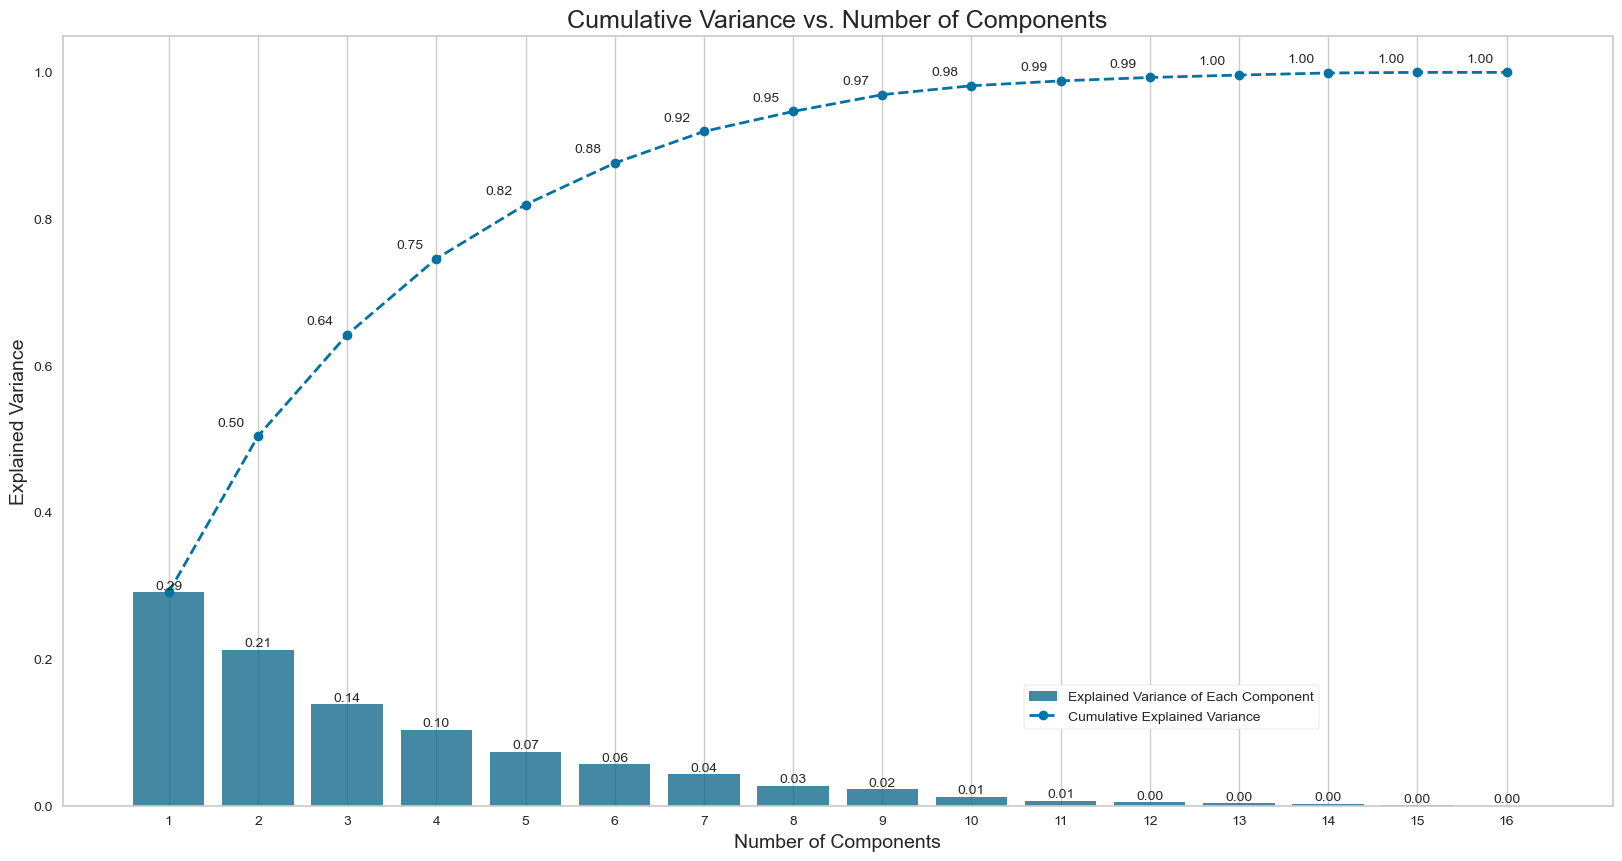

In [19]:
np.random.seed(42)

U, S, VT = np.linalg.svd(data_scaled_df, full_matrices=False)

explained_variance = (S ** 2) / np.sum(S ** 2) # Explained variance
svd_projection = U[:, :2] @ np.diag(S[:2]) # 2D SVD Projection

#sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance,
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--',  linewidth=2)

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           )  

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()


The plot and the cumulative explained variance values indicate how much of the total variance in the dataset is captured by each component, as well as the cumulative variance explained by the first n components.

Here, we can observe that:

The first component explains approximately 31% of the variance.\
The first two components together explain about 54% of the variance.\
The first six components explain approximately 88% of the variance, and so on.

Choosing optimal number of components as 6 after which adding another component doesn't significantly increase in the cummulative variance, often referred to as the "elbow point" in the curve.

From the plot, we can see that the increase in cumulative variance starts to slow down after the 6th component (which captures about 88% of the total variance) and also adding another component has no change in the variance of the individua component.


## PCA

In [20]:
# performing PCA with 9 components
pca = PCA(n_components=6)
F1_data_pca = pca.fit_transform(data_scaled_df)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
F1_data_pca = pd.DataFrame(F1_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

id_index = final_data[["raceId", "driverId"]].reset_index(drop=True)
pca_df = pd.concat([id_index, F1_data_pca], axis=1).set_index(["raceId", "driverId"])
pca_df = pca_df.reset_index()
pca_df.head()


,raceId,driverId,PC1,PC2,PC3,PC4,PC5,PC6
0,841,20,-1.454654,2.467678,-0.395891,-0.405817,0.197826,-0.369316
1,841,1,-0.852697,1.307286,-0.500208,-0.520739,0.199261,-0.652279
2,841,808,-0.563475,-0.022435,-0.643267,1.149230,-0.113728,0.262184
3,841,4,-0.646255,0.312125,-0.114757,0.235873,0.206241,1.254385
4,841,17,-0.756625,0.405742,0.096841,-1.191356,0.212870,1.058389


In [21]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce to 2 dimensions for visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(data_scaled_df)

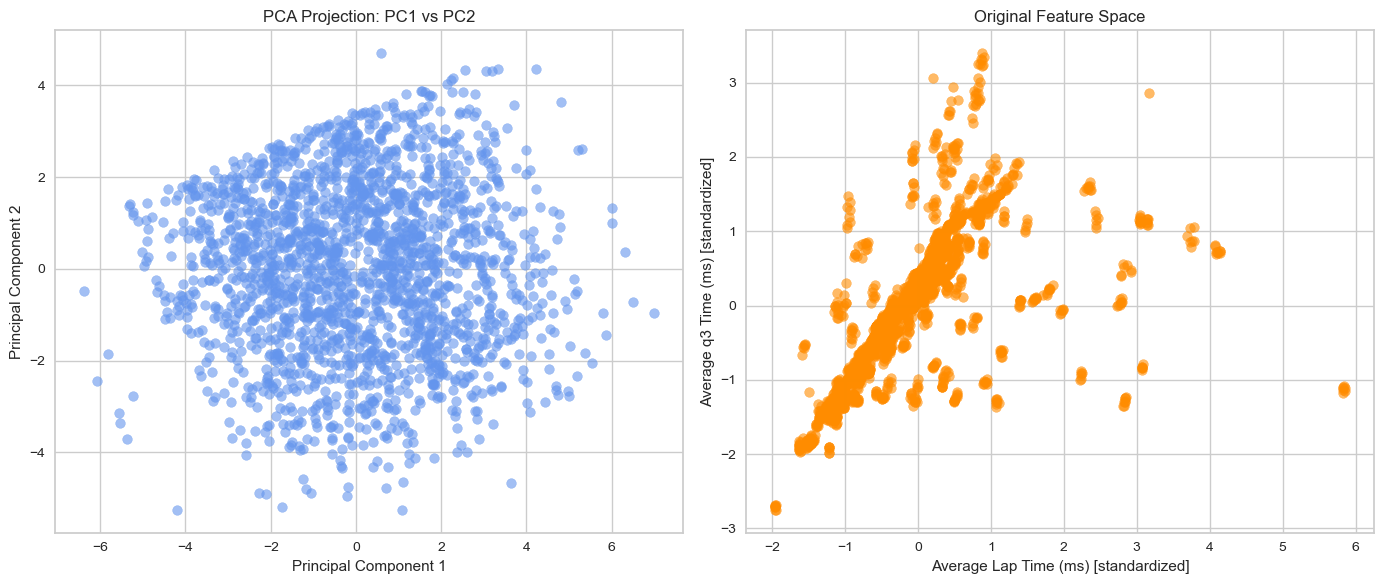

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot 1: PCA projection (PC1 vs PC2)
axs[0].scatter(F1_data_pca['PC1'], F1_data_pca['PC2'], alpha=0.6, color='cornflowerblue')
axs[0].set_title("PCA Projection: PC1 vs PC2")
axs[0].set_xlabel("Principal Component 1")
axs[0].set_ylabel("Principal Component 2")
axs[0].grid(True)

# --- Plot 2: Original features (avg_lap_time vs average_pit_duration)
axs[1].scatter(data_scaled_df_copy['avg_lap_time_ms'], data_scaled_df_copy['q3_ms'], alpha=0.6, color='darkorange')
axs[1].set_title("Original Feature Space")
axs[1].set_xlabel("Average Lap Time (ms) [standardized]")
axs[1].set_ylabel("Average q3 Time (ms) [standardized]")
axs[1].grid(True)

plt.tight_layout()
plt.show()

There is no clear seperation between the data when we visualize the 2 components of PCA. Next we try to perform K-mean on this data to visualize the clusters. 

In [23]:
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=data_scaled_df.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
grid,0.152734,-0.378691,-0.078314,0.447781,0.003427,0.123384
finalPosition,0.167506,-0.453206,0.019497,-0.263958,0.028400,0.081915
points,-0.164398,0.458953,-0.004199,0.197710,-0.021615,-0.090173
Total_time_ms,0.052056,-0.021915,0.597753,0.102366,-0.173509,-0.187021
fastestLap,-0.241297,-0.078886,0.111464,0.032653,-0.282897,0.381710
fastesLapRank,0.155376,-0.357945,-0.063381,-0.091202,-0.045254,-0.370206
fastestLapSpeed,-0.033061,0.016724,-0.233901,-0.012725,0.792781,0.209529
qualifyingPosition,0.160590,-0.416327,-0.053051,0.290780,-0.010428,0.067910
total_pit_stops,0.004263,-0.017461,0.376780,-0.077143,0.031884,0.715291
average_pit_duration_ms,0.027882,-0.019915,0.466359,0.109448,0.462281,-0.228829


C:\Users\Hrishabh\AppData\Local\Temp\ipykernel_9720\4261243076.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", 10)


NameError: name 'angle' is not defined

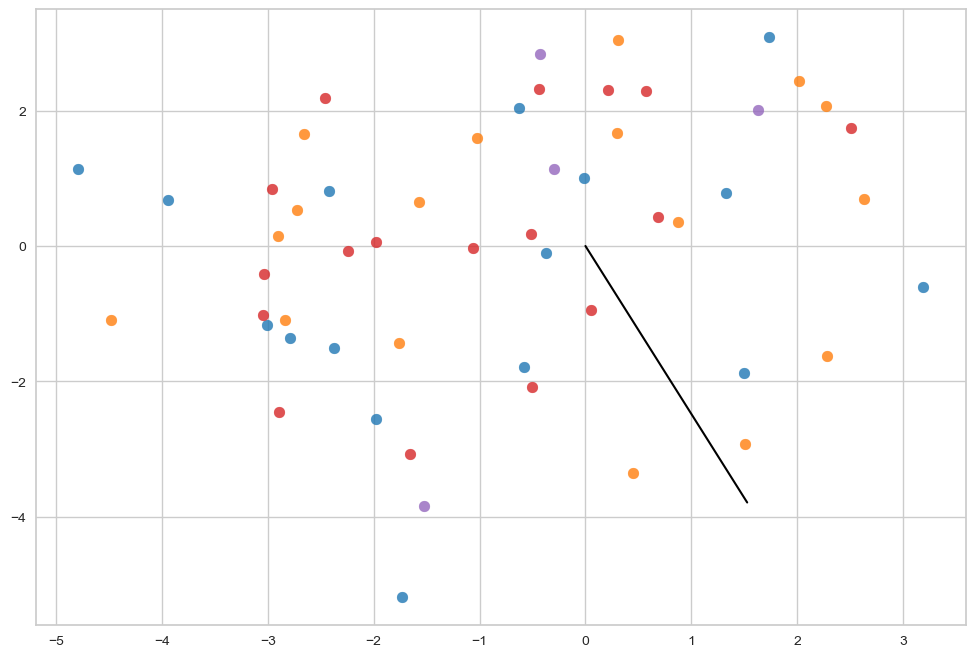

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
scaling_factor = 9
# Intersect with valid raceIds
selected_drivers = ['hamilton', 'vettel', 'max_verstappen', 'alonso', 'ricciardo']
#selected_races = [841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 861, 862, 863, 864, 865, 866, 867, 868, 869]  # Example raceIds
#selected_races = list(range(1000, 1010))
selected_races = list(range(880, 900))
# Filter the merged dataframe
subset = merged[(merged['driverRef'].isin(selected_drivers)) & (merged['raceId'].isin(selected_races))].copy()

# Get the aligned scaled data
subset_scaled = data_scaled_df_copy.loc[subset.index]
subset_pca = pd.DataFrame(pca_2d.transform(subset_scaled), columns=['PC1', 'PC2'], index=subset.index)
colors = plt.cm.get_cmap("tab10", 10)
# Plot setup
fig, ax = plt.subplots(figsize=(12, 8))

# Plot PCA scores for each driver
for i, driver in enumerate(selected_drivers):
    idx = subset[subset['driverRef'] == driver].index
    ax.scatter(subset_pca.loc[idx, 'PC1'], subset_pca.loc[idx, 'PC2'],
               color=colors(i), label=driver, alpha=0.8, s=60)
line_length = 10         # Keeps arrow/line the same        # Keeps arrow/line the same
label_offset = 10        # Increase this to spread out text more

for i, (x_comp, y_comp) in enumerate(pca_2d.components_.T):
    # Line (arrow without head)
    ax.plot([0, x_comp * line_length], [0, y_comp * line_length], color='black', linewidth=1.5)

    # Text with increased spacing and rotation
    angle_rad = np.arctan2(y_comp, x_comp)
    angle_deg = np.degrees(angle_rad)

# Flip upside-down labels to keep them upright
    if angle_deg > 90 or angle_deg < -90:
        angle_deg += 180
    ax.text(x_comp * label_offset, 
            y_comp * label_offset,
            data_scaled_df_copy.columns[i],
            fontsize=11, color='darkred',
            rotation=angle, rotation_mode='anchor',
            ha='center', va='center')

# Annotate 10 driver-race combos
#np.random.seed(42)
label_idx = np.random.choice(subset.index, size=30, replace=False)
for i in label_idx:
    label = subset.loc[i, 'driverRef'] + "_race" + str(subset.loc[i, 'raceId'])
    ax.text(subset_pca.loc[i, 'PC1'], subset_pca.loc[i, 'PC2'], label, fontsize=9)

# Aesthetics
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("PCA Projection with driver/race combo")
ax.axhline(0, color='gray', lw=0.5)
ax.axvline(0, color='gray', lw=0.5)
ax.grid(True)
ax.legend(title="Driver")
plt.tight_layout()
plt.show()


/var/folders/y4/fkn560k16c3__twnyy0m4jxr0000gn/T/ipykernel_15648/32344679.py:25: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



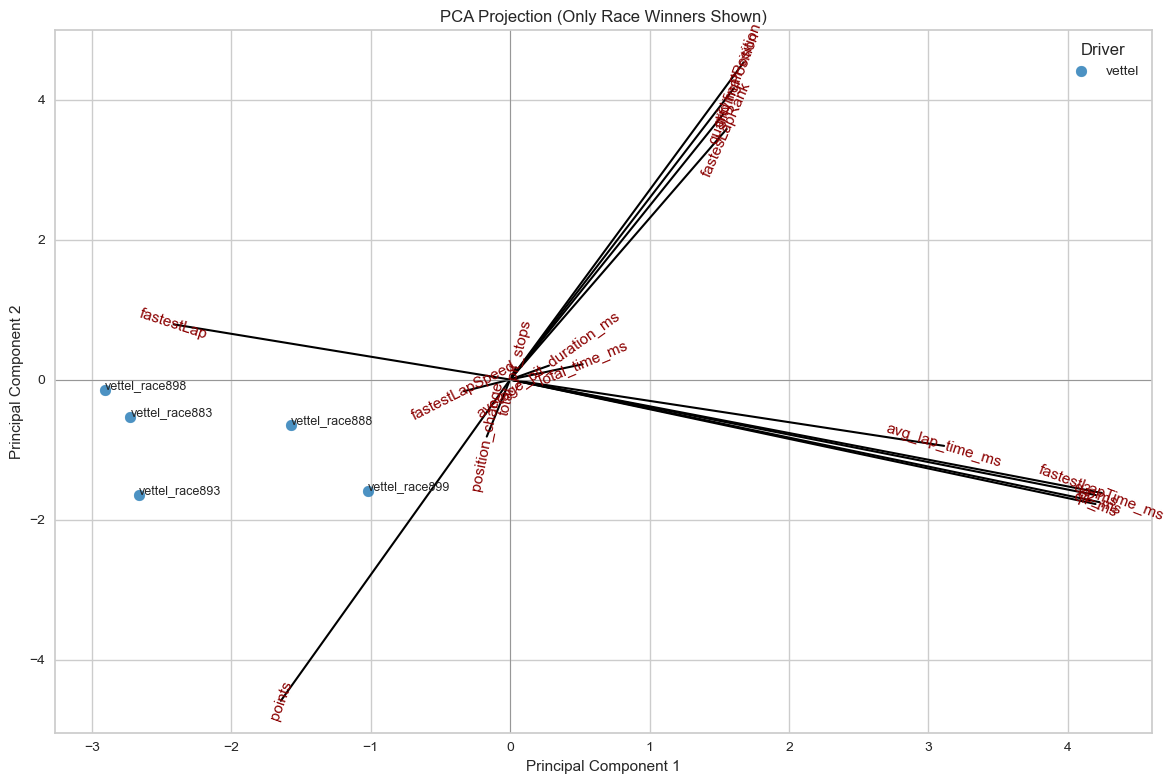

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

scaling_factor = 9
line_length = 10
label_offset = 10

# Define your selected drivers and races
selected_drivers = ['vettel']
#selected_races = list(range(880, 900))
selected_races = [883, 888, 893, 898, 899]

# Filter the merged dataframe for selected drivers and races
subset_all = merged[(merged['driverRef'].isin(selected_drivers)) & (merged['raceId'].isin(selected_races))].copy()

# Filter only winning entries (final position == 1)
subset = subset_all[subset_all['finalPosition'] == 1].copy()

# Get the aligned scaled data
subset_scaled = data_scaled_df_copy.loc[subset.index]
subset_pca = pd.DataFrame(pca_2d.transform(subset_scaled), columns=['PC1', 'PC2'], index=subset.index)

colors = plt.cm.get_cmap("tab10", 10)

# Plot setup
fig, ax = plt.subplots(figsize=(12, 8))

# Plot PCA scores for each winner
for i, driver in enumerate(selected_drivers):
    idx = subset[subset['driverRef'] == driver].index
    ax.scatter(subset_pca.loc[idx, 'PC1'], subset_pca.loc[idx, 'PC2'],
               color=colors(i), label=driver, alpha=0.8, s=60)

# Plot PCA directions
for i, (x_comp, y_comp) in enumerate(pca_2d.components_.T):
    ax.plot([0, x_comp * line_length], [0, y_comp * line_length], color='black', linewidth=1.5)
    angle_rad = np.arctan2(y_comp, x_comp)
    angle_deg = np.degrees(angle_rad)
    if angle_deg > 90 or angle_deg < -90:
        angle_deg += 180
    ax.text(x_comp * label_offset,
            y_comp * label_offset,
            data_scaled_df_copy.columns[i],
            fontsize=11, color='darkred',
            rotation=angle_deg, rotation_mode='anchor',
            ha='center', va='center')

# Label the winning driver-race combos
for i in subset.index:
    label = subset.loc[i, 'driverRef'] + "_race" + str(subset.loc[i, 'raceId'])
    ax.text(subset_pca.loc[i, 'PC1'], subset_pca.loc[i, 'PC2'], label, fontsize=9)

# Aesthetics
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("PCA Projection (Only Race Winners Shown)")
ax.axhline(0, color='gray', lw=0.5)
ax.axvline(0, color='gray', lw=0.5)
ax.grid(True)
ax.legend(title="Driver")
plt.tight_layout()
plt.show()


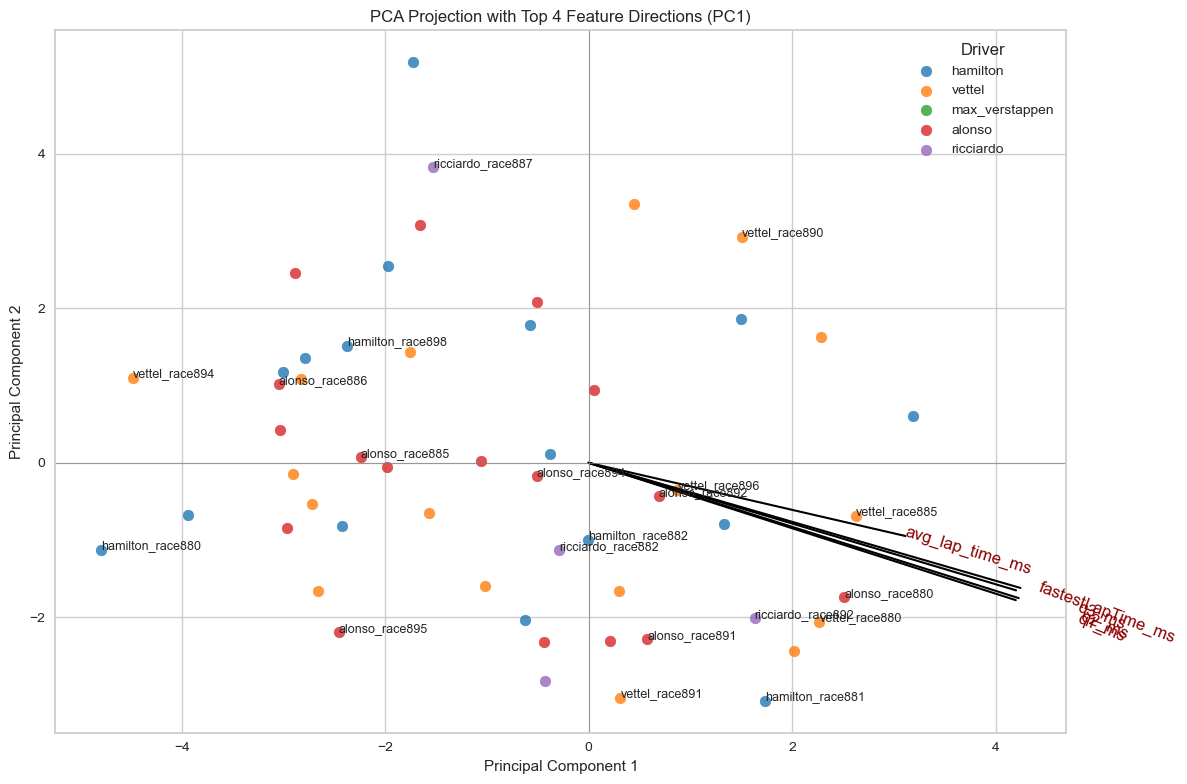

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract loadings from PCA (assuming pca_2d is already fit with 2 components)
loadings = pd.DataFrame(pca_2d.components_.T, 
                        columns=['PC1', 'PC2'], 
                        index=data_scaled_df_copy.columns)

# Step 1: Get top 4 features by magnitude for either PC1 or PC2
# Option 1: Based on PC1
top_features = loadings['PC1'].abs().nlargest(5).index

# Option 2: Based on PC2 instead
# top_features = loadings['PC2'].abs().nlargest(4).index

# Step 2: Subset the loadings DataFrame to include only those features
top_loadings = loadings.loc[top_features]

# Plot setup
fig, ax = plt.subplots(figsize=(12, 8))

# Plot PCA scores
for i, driver in enumerate(selected_drivers):
    idx = subset[subset['driverRef'] == driver].index
    ax.scatter(subset_pca.loc[idx, 'PC1'], subset_pca.loc[idx, 'PC2'],
               color=colors(i), label=driver, alpha=0.8, s=60)

# Plot top 4 PCA directions (lines only)
line_length = 10
label_offset = 12

for i, feature in enumerate(top_features):
    x_comp, y_comp = top_loadings.loc[feature]
    ax.plot([0, x_comp * line_length], [0, y_comp * line_length], color='black', linewidth=1.5)
    
    # Rotate feature label along direction
    angle_rad = np.arctan2(y_comp, x_comp)
    angle_deg = np.degrees(angle_rad)
    if x_comp < 0:
        angle_deg += 180

    ax.text(x_comp * label_offset, 
            y_comp * label_offset,
            feature,
            fontsize=12, color='darkred',
            rotation=angle_deg, rotation_mode='anchor',
            ha='center', va='center')

# Optional: Annotate a few driver/race combos
label_idx1 = np.random.choice(subset.index, size=20, replace=False)
for i in label_idx1:
    label = subset.loc[i, 'driverRef'] + "_race" + str(subset.loc[i, 'raceId'])
    ax.text(subset_pca.loc[i, 'PC1'], subset_pca.loc[i, 'PC2'], label, fontsize=9)

# Aesthetics
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("PCA Projection with Top 4 Feature Directions (PC1)")
ax.axhline(0, color='gray', lw=0.5)
ax.axvline(0, color='gray', lw=0.5)
ax.grid(True)
ax.legend(title="Driver")
plt.tight_layout()
plt.show()


## K Means

### Determining the optimal number of clusters


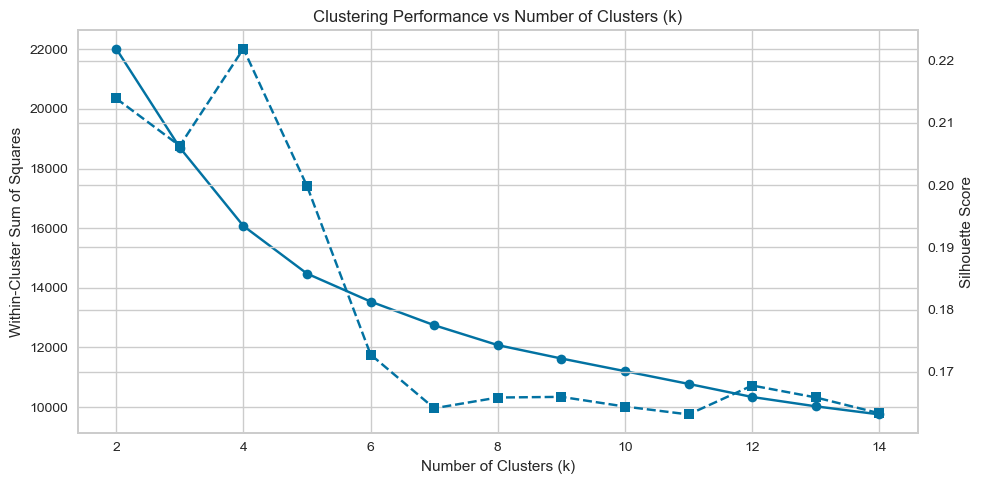

In [ ]:
ks = range(2, 15)
wss = []
silhouette_scores = []

for k in ks:
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = kmeans.fit_predict(F1_data_pca)
    wss.append(kmeans.inertia_)
    sil_score = silhouette_score(F1_data_pca, labels)
    silhouette_scores.append(sil_score)

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Within-Cluster Sum of Squares')
ax1.plot(ks, wss, marker='o', label='WSS')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score')
ax2.plot(ks, silhouette_scores, marker='s', linestyle='--', label='Silhouette')
ax2.tick_params(axis='y')

plt.title('Clustering Performance vs Number of Clusters (k)')
fig.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=9, max_iter=100, random_state=0)
kmeans.fit(F1_data_pca)

# Optional: get cluster frequencies
cluster_frequencies = Counter(kmeans.labels_)

# Optional: sort clusters by size (optional relabeling)
sorted_clusters = [c for c, _ in cluster_frequencies.most_common()]
relabel = {old: new for new, old in enumerate(sorted_clusters)}
new_labels = np.array([relabel[l] for l in kmeans.labels_])

# Add cluster labels
F1_data_pca["cluster"] = new_labels
data_scaled_df["cluster"] = new_labels

In [ ]:
data_scaled_df.head()

,grid,finalPosition,points,Total_time_ms,fastestLap,fastesLapRank,fastestLapSpeed,qualifyingPosition,total_pit_stops,average_pit_duration_ms,avg_lap_time_ms,position_change,fastestLapTime_ms,q1_ms,q2_ms,q3_ms,cluster
0,-1.290033,-1.235402,1.737068,-0.439229,-0.391093,-0.513603,0.236956,-1.414751,-0.027390,-0.269378,-0.389816,-0.048314,-0.065757,-0.250179,-0.293561,-0.325067,0
1,-0.964747,-0.912358,0.794654,-0.420336,-0.635854,0.465612,0.184532,-1.046952,-0.027390,-0.269930,-0.369424,-0.048314,-0.025557,-0.243077,-0.252019,-0.262457,0
2,0.336397,-0.589315,0.390762,-0.413335,0.506365,0.220808,0.212356,0.424243,-0.027390,-0.260102,-0.361867,0.975400,-0.046940,-0.230246,-0.170826,-0.186809,0
3,0.011111,-0.266271,-0.013130,-0.412308,0.016842,-1.003211,0.277152,0.056444,1.016529,-0.265566,-0.360759,0.292924,-0.096292,-0.217011,-0.198795,-0.208779,0
4,-0.639461,0.056772,-0.282391,-0.406886,0.098430,-0.758407,0.264354,-0.679154,1.016529,-0.265547,-0.354907,-0.730789,-0.086627,-0.201436,-0.246836,-0.255375,0


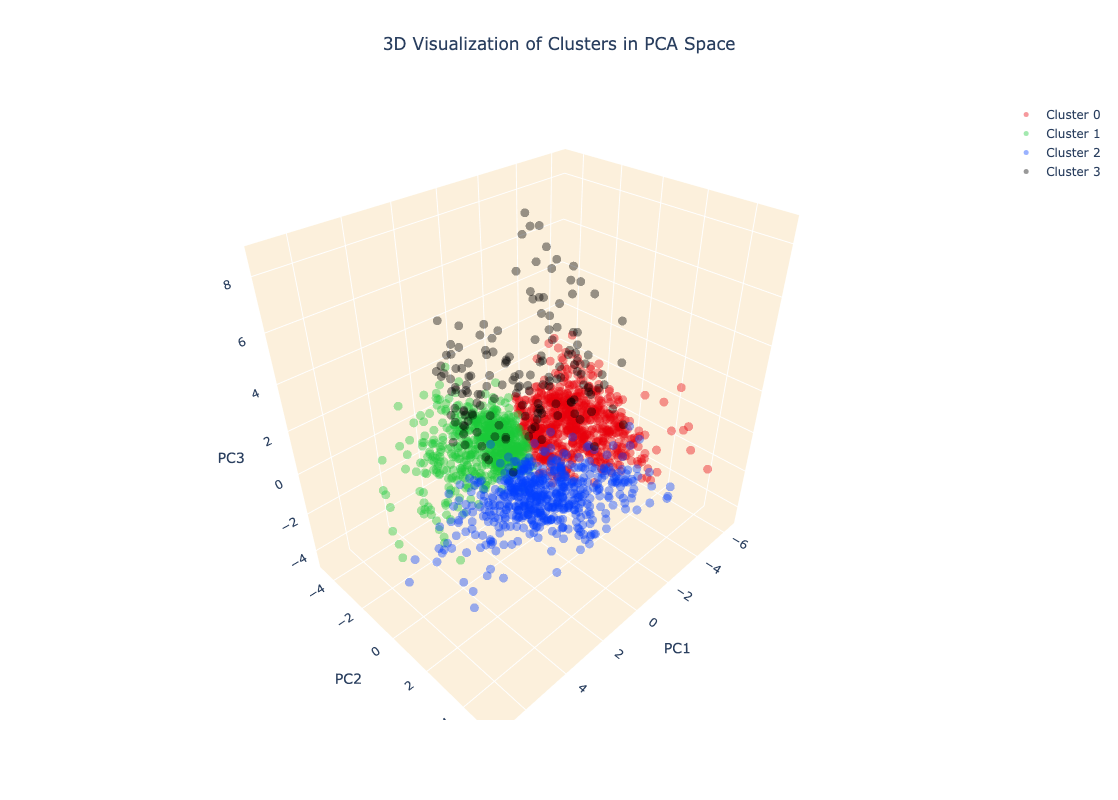

In [ ]:
colors = ['#e8000b', '#1ac938', '#023eff', '#000000']
cluster_0 = F1_data_pca[F1_data_pca['cluster'] == 0]
cluster_1 = F1_data_pca[F1_data_pca['cluster'] == 1]
cluster_2 = F1_data_pca[F1_data_pca['cluster'] == 2]
cluster_3 = F1_data_pca[F1_data_pca['cluster'] == 3]
# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))
fig.add_trace(go.Scatter3d(x=cluster_3['PC1'], y=cluster_3['PC2'], z=cluster_3['PC3'], 
                           mode='markers', marker=dict(color=colors[3], size=5, opacity=0.4), name='Cluster 3'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

In [ ]:
num_observations = len(F1_data_pca)

# Separate the features and the cluster labels
X = F1_data_pca.drop('cluster', axis=1)
clusters = F1_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+------------------------+---------------------+
|         Metric         |        Value        |
+------------------------+---------------------+
| Number of Observations |        2020         |
|    Silhouette Score    | 0.22271686078883224 |
+------------------------+---------------------+


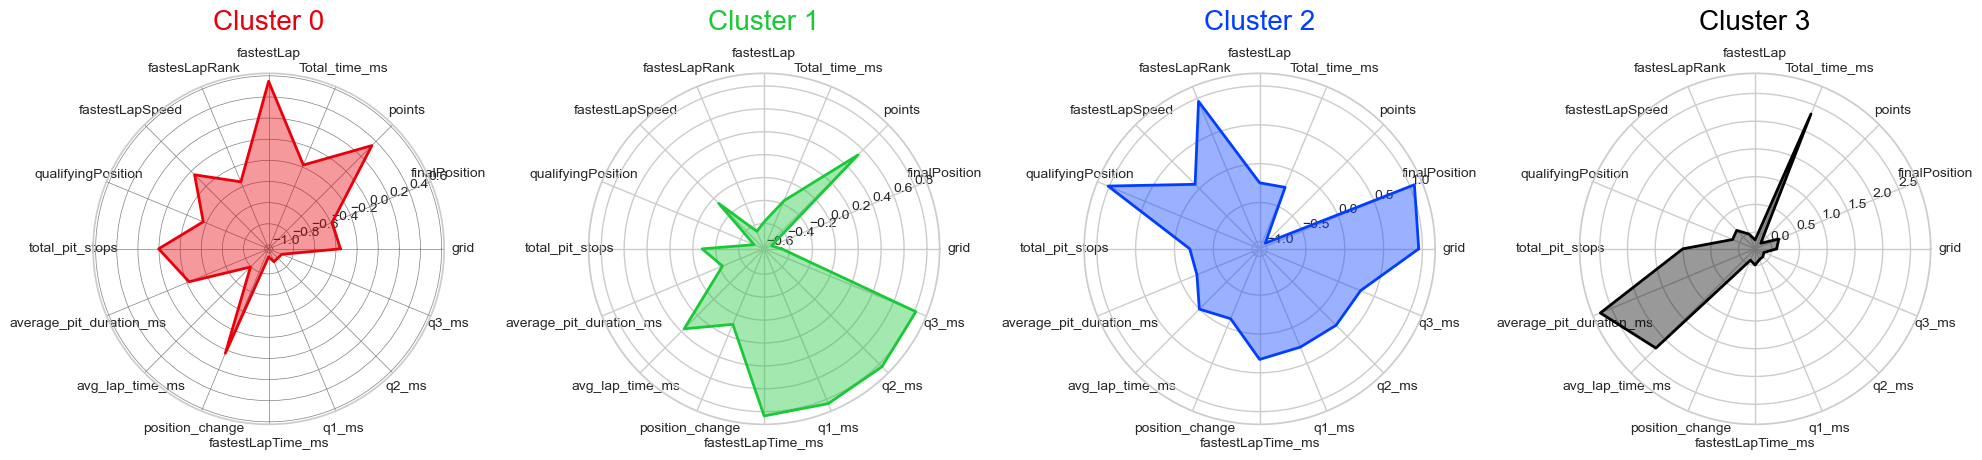

In [ ]:
colors = ['#e8000b', '#1ac938', '#023eff', '#000000']

# Standardize the data (excluding the cluster column)
#scaler = StandardScaler()
df_standardized = data_scaled_df.copy()

# Create a new dataframe with standardized values and add the cluster column back
df_standardized = pd.DataFrame(data_scaled_df, columns=data_scaled_df.columns[:-1], index=data_scaled_df.index)
df_standardized['cluster'] = data_scaled_df['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=4)

# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Add input data
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

ax[3].set_xticks(angles[:-1])
ax[3].set_xticklabels(labels[:-1])

# Add a grid
ax[0].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

Interpretation from radar chart\
Cluster 0 (Red)\
High on: fastestLap, points, positionOrder(final position)\
Low on: position_change (negative) and qualifyingPosition\
Interpretation:
These drivers tend to finish at the top with fast lap times and strong race-day performance, even if they lose positions relative to their start. Possibly consistent, fast finishers.

Cluster 1 (Green)\
High on: q1_ms, q2_ms, q3_ms (longer times), position_change

Low on: race outcomes like points, positionOrder, grid\

Interpretation:
Drivers in this group qualify poorly (slow qualifying laps) and often start at the back — but show strong racecraft, gaining positions during the race. Possibly skilled midfielders or rookies.

Cluster 2 (Blue)\
High on: fastestLapSpeed, qualifyingPosition, positionOrder

Low on: points, pit_stops, avg_lap_time_ms

Interpretation:
Drivers in this cluster are excellent qualifiers, with strong lap speeds, but may not convert those into high points. Possibly inconsistent performers or drivers in weaker cars.

Cluster 3 (Black)\
High on: average_pit_duration_ms, total_pit_stops, Total_time_ms

Low on: everything else

Interpretation:
Likely poor performers or drivers impacted by long pit stops, technical issues, or penalties. These could be backmarkers or those who don’t finish well

# Hierarchical Clustering

In [ ]:
linkage_methods = ['single', 'complete', 'average', 'centroid']
cluster_numbers  = [2, 3, 4, 5, 6]

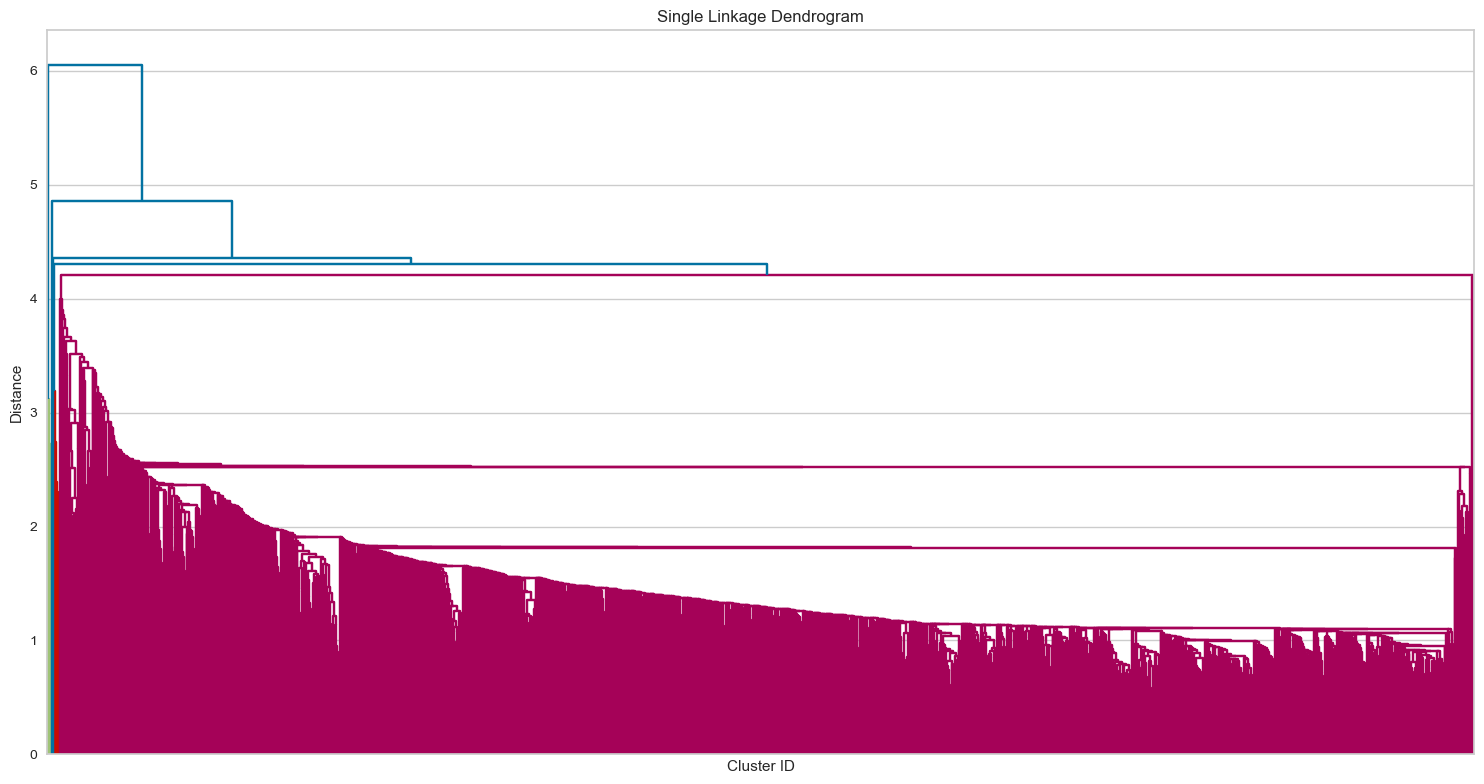


 Single linkage:
k =  2  ->  cluster sizes: [7, 2013]
k =  3  ->  cluster sizes: [7, 2012, 1]
k =  4  ->  cluster sizes: [7, 2011, 1, 1]
k =  5  ->  cluster sizes: [7, 9, 2002, 1, 1]
k =  6  ->  cluster sizes: [7, 9, 1999, 3, 1, 1]


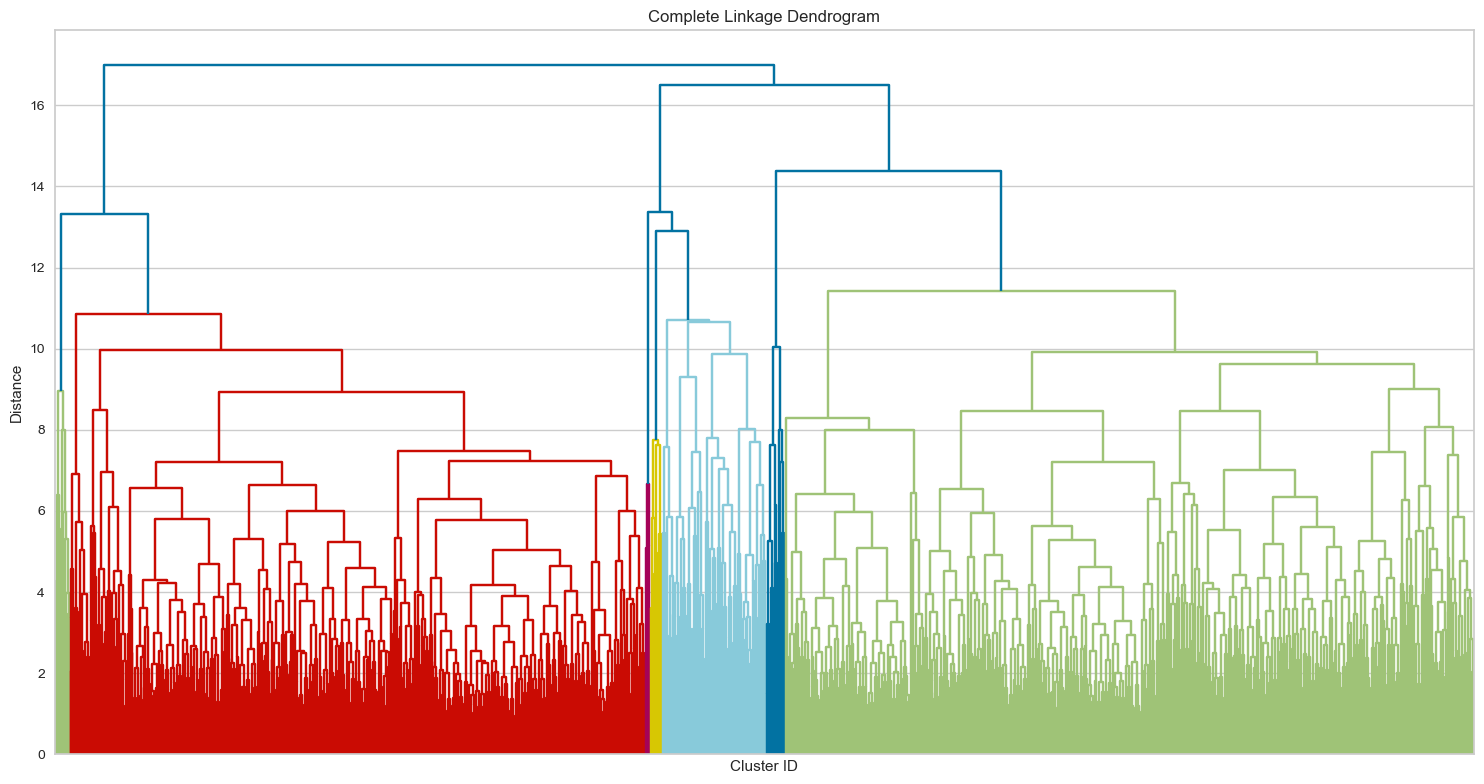


 Complete linkage:
k =  2  ->  cluster sizes: [841, 1179]
k =  3  ->  cluster sizes: [841, 172, 1007]
k =  4  ->  cluster sizes: [841, 172, 27, 980]
k =  5  ->  cluster sizes: [841, 7, 165, 27, 980]
k =  6  ->  cluster sizes: [22, 819, 7, 165, 27, 980]


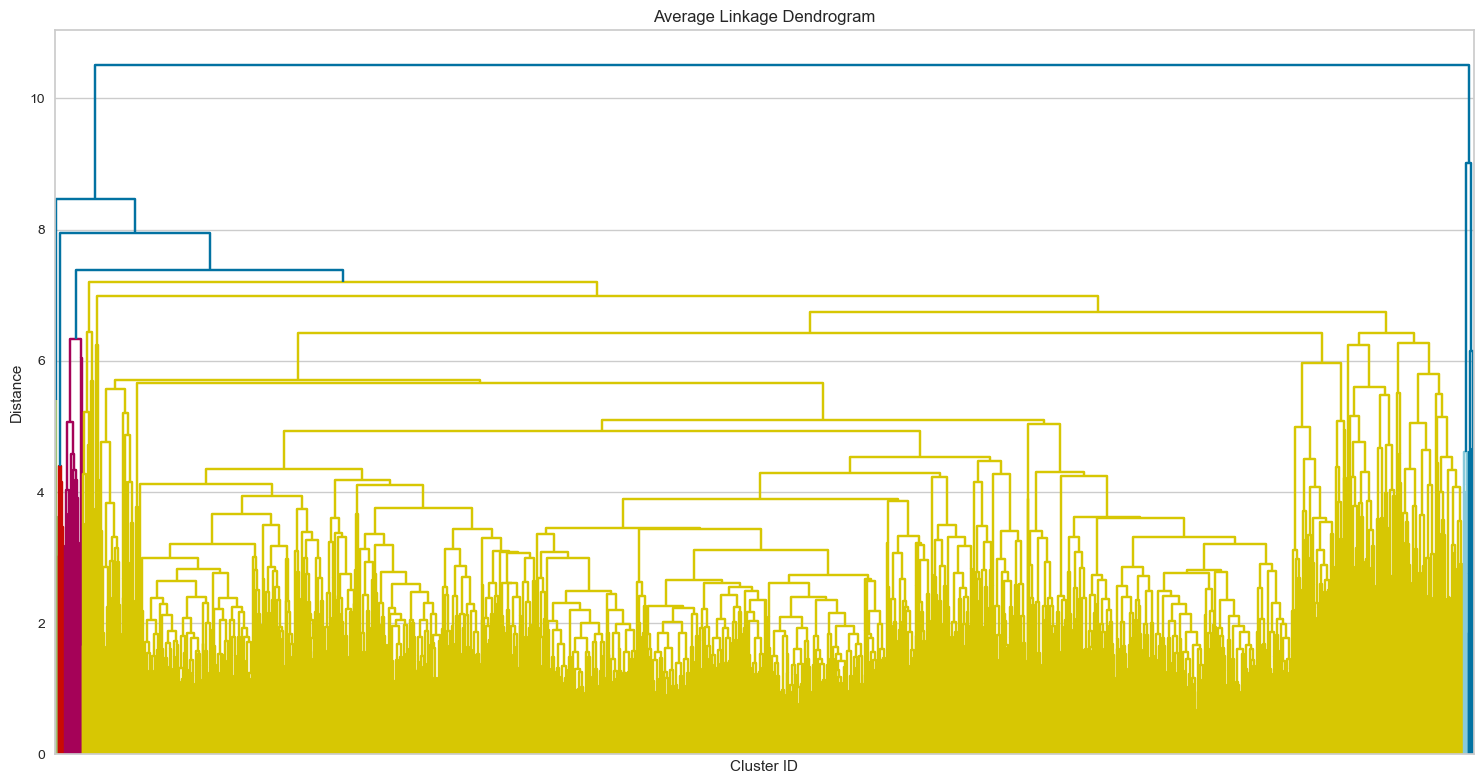


 Average linkage:
k =  2  ->  cluster sizes: [2005, 15]
k =  3  ->  cluster sizes: [2005, 7, 8]
k =  4  ->  cluster sizes: [5, 2000, 7, 8]
k =  5  ->  cluster sizes: [5, 9, 1991, 7, 8]
k =  6  ->  cluster sizes: [5, 9, 25, 1966, 7, 8]


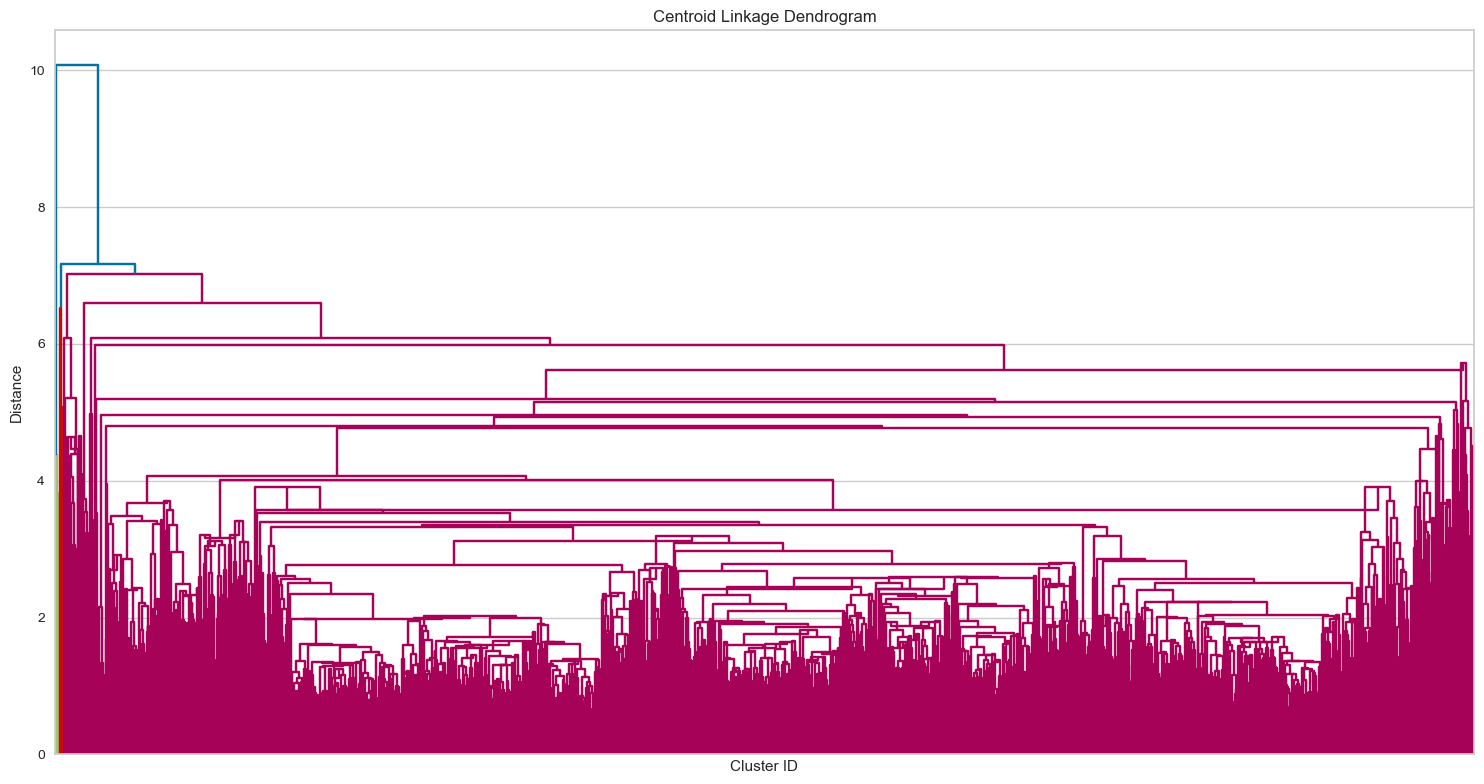


 Centroid linkage:
k =  2  ->  cluster sizes: [7, 2013]
k =  3  ->  cluster sizes: [7, 6, 2007]
k =  4  ->  cluster sizes: [7, 6, 27, 1980]
k =  5  ->  cluster sizes: [7, 6, 27, 9, 1971]
k =  6  ->  cluster sizes: [7, 5, 1, 27, 9, 1971]


In [ ]:
# Looping through each types of linkage
for method in linkage_methods:

    Z = linkage(X_scaled, method=method, metric='euclidean')

    # Ploting all dendrogram
    plt.figure(figsize=(15, 8))
    dendrogram(
        Z, leaf_rotation=90, leaf_font_size=6, color_threshold=None, no_labels=True
    )
    plt.title(f"{method.capitalize()} Linkage Dendrogram")
    plt.xlabel("Cluster ID")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()

    # Trying out different numbers of flat clusters
    print(f"\n {method.capitalize()} linkage:")
    for k in cluster_numbers:
        labels = fcluster(Z, t=k, criterion='maxclust')
        # bincount returns the counts for labels 1… k
        sizes = np.bincount(labels)[1:]
        print(f"k = {k:>2}  ->  cluster sizes: {sizes.tolist()}")

Key Observations:

--- Single linkage : 
- Extremely imbalanced clusters at every k
- One massive cluster plus very small clusters observed

--- Complete linkage
- It Produces more balanced mid-sized clusters at moderate values of k like 4, 5, 6
- It still isolates some true outliers but captures two or three main grouping among the bulk of the data.

--- Average and Centroid linkage
- Both are giving outcomes similar to the single linkage.
- One dominating cluster and other very small clusters/ few outliers.

### Scaling

In [ ]:
drop_cols = [
    "raceId","constructorId","circuitId", "statusId","round","year","laps","hc_cluster"
]
# Here, numeric features only considered, then dropping unwanted columns
numeric_cols = final_data.select_dtypes(include="number").columns
features = final_data[numeric_cols].drop(columns=drop_cols, errors="ignore")

In [ ]:
# Selected random sub-sample of 100 rows for dendrogram
n_samples = 100
sub_idx   = np.random.choice(features.index, size=n_samples, replace=False)
X_sub     = features.loc[sub_idx]

driver_ids = final_data.loc[sub_idx, 'driverId'].astype(str).values

# Now, lets scale sub-sampled data
scaler     = StandardScaler()
X_scaled   = scaler.fit_transform(X_sub)
scaled_df  = pd.DataFrame(X_scaled, columns=X_sub.columns, index=X_sub.index)

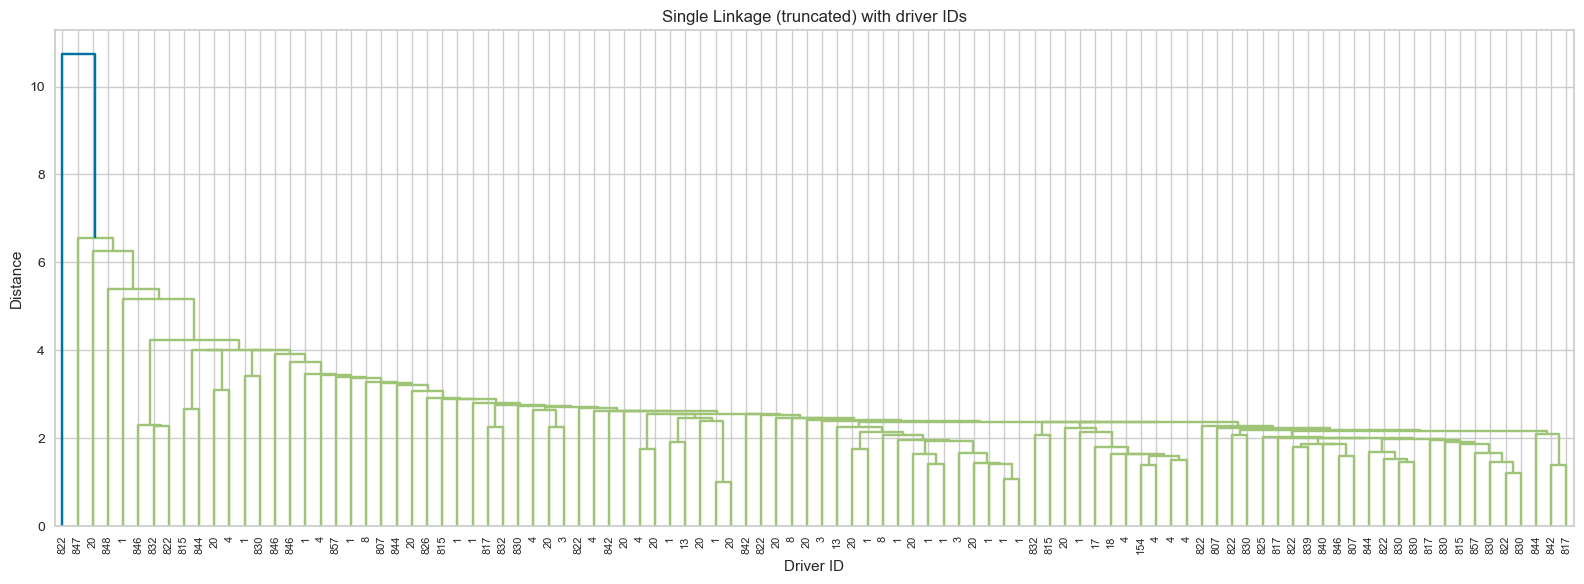


Single linkage flat clusters (n=100):
k=2  -> sizes = [99, 1]
k=3  -> sizes = [98, 1, 1]
k=4  -> sizes = [97, 1, 1, 1]
k=5  -> sizes = [96, 1, 1, 1, 1]
k=6  -> sizes = [95, 1, 1, 1, 1, 1]


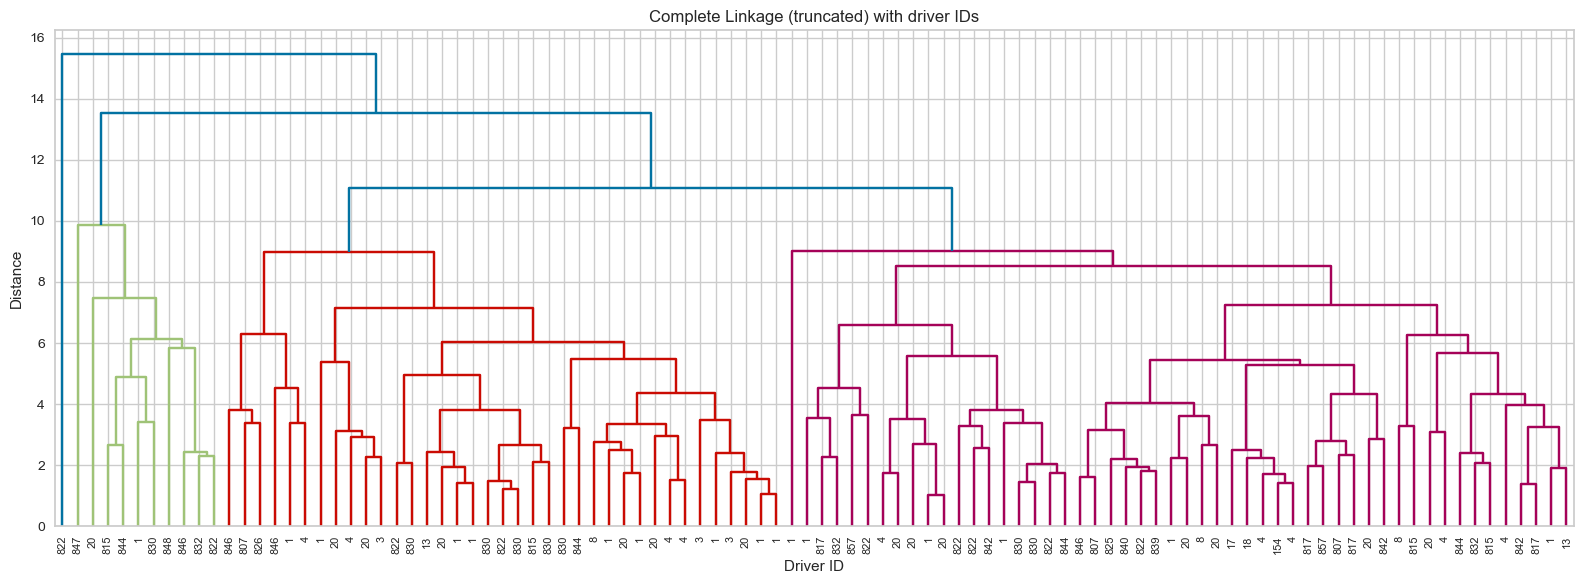


Complete linkage flat clusters (n=100):
k=2  -> sizes = [99, 1]
k=3  -> sizes = [10, 89, 1]
k=4  -> sizes = [10, 37, 52, 1]
k=5  -> sizes = [9, 1, 37, 52, 1]
k=6  -> sizes = [9, 1, 37, 51, 1, 1]


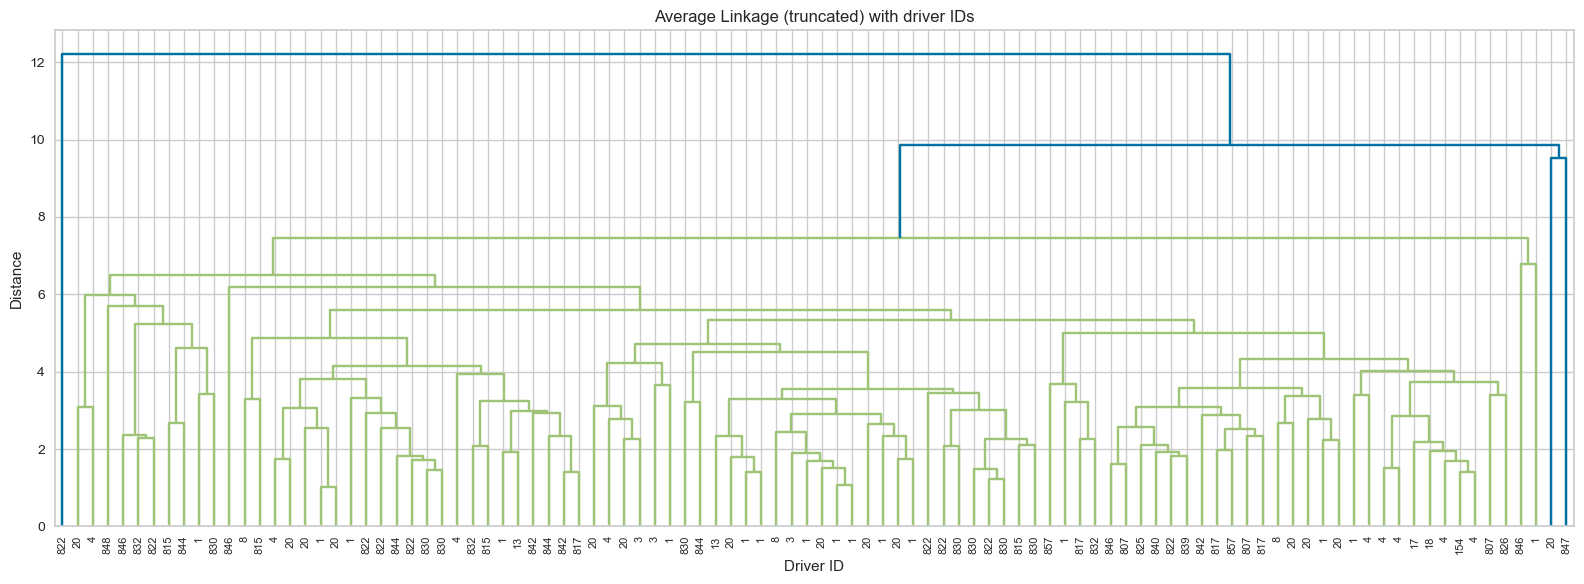


Average linkage flat clusters (n=100):
k=2  -> sizes = [99, 1]
k=3  -> sizes = [97, 2, 1]
k=4  -> sizes = [97, 1, 1, 1]
k=5  -> sizes = [95, 2, 1, 1, 1]
k=6  -> sizes = [95, 1, 1, 1, 1, 1]


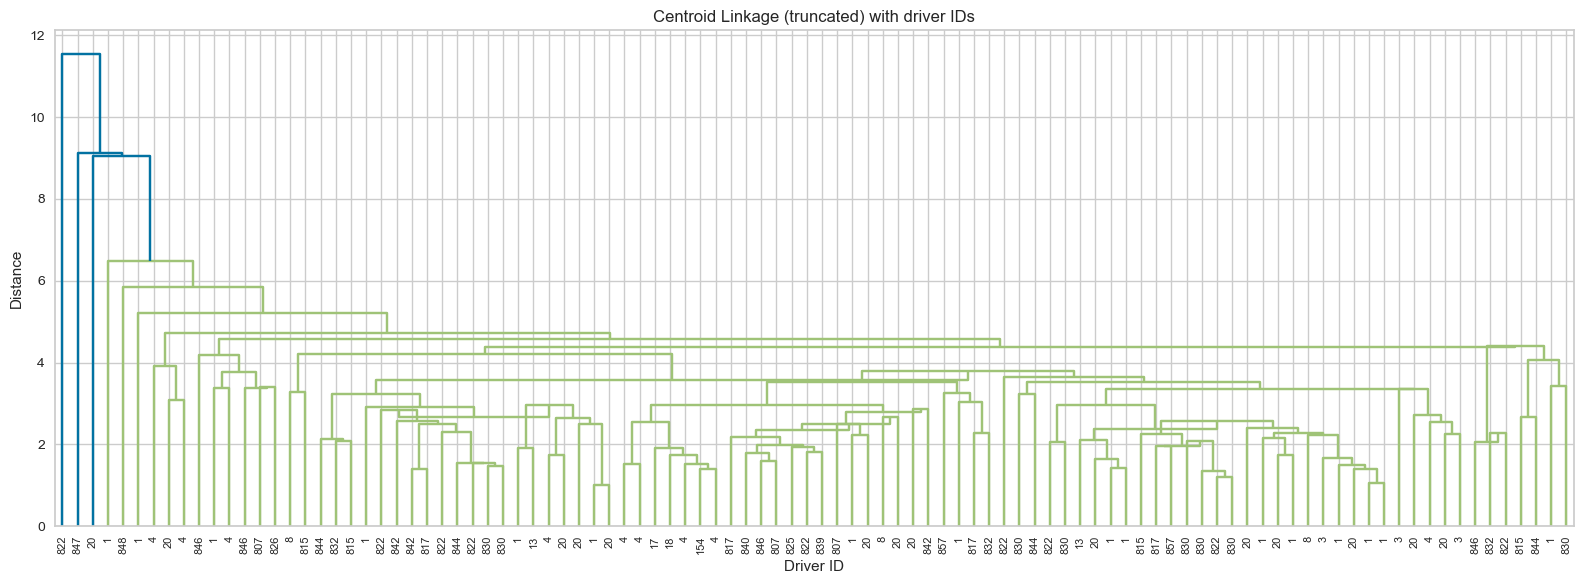


Centroid linkage flat clusters (n=100):
k=2  -> sizes = [99, 1]
k=3  -> sizes = [98, 1, 1]
k=4  -> sizes = [97, 1, 1, 1]
k=5  -> sizes = [96, 1, 1, 1, 1]
k=6  -> sizes = [95, 1, 1, 1, 1, 1]


In [ ]:
# Linkage computation and dendrograms plots
linkage_methods = ['single','complete','average','centroid']
for method in linkage_methods:
    Z = linkage(X_scaled, method=method, metric='euclidean')

    plt.figure(figsize=(16, 6))
    dendrogram(
        Z, 
        labels = driver_ids,
        leaf_rotation=90,
        leaf_font_size=8,
    )
    plt.title(f"{method.capitalize()} Linkage (truncated) with driver IDs")
    plt.xlabel("Driver ID")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()

    # 4) Extract flat clusters on the full linkage of the sub-sample
    print(f"\n{method.capitalize()} linkage flat clusters (n={n_samples}):")
    for k in [2, 3, 4, 5, 6]:
        labels = fcluster(Z, t=k, criterion='maxclust')
        sizes  = np.bincount(labels)[1:]
        print(f"k={k:<2} -> sizes = {sizes.tolist()}")

We first considered 100 sub-sampled data, scaled the subsampled numeric features dropping non-numeric columns.

Effect of feature scaling on:

--- Single:
- Normalizing the features slightly changes the linkage distances still forms one giant cluster containing almost all points, with each outlier split off.

--- Complete:
- More balanced groupings as scaling yields two or three mid-sized clusters instead of a single massive one.
- Outliers continue to be isolated as tiny clusters, but is now spread more evenly across clusters. 
- It seems to be the best linkage type for this dataset as it is properly or efficiently dividing the scaled data into clusters.

--- Average:
- Still produces one dominant cluster holding most points, plus a smaller secondary cluster and a few singleton outliers. 

--- Centroid:
- Scaling makes centroid calculations more stable, but the big cluster and outliers persists. 



--- Difference observed after scaling data:

- Scaling balances the influence of each feature, so no single variable with a large range dominates the clustering.
- Complete linkage benefits most, producing noticeably more even cluster sizes once features are standardized.
- Single, average, and centroid linkages remain largely unchanged in pattern.